## Imports

In [12]:
import xarray as xr

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from xhistogram.xarray import histogram
import matplotlib.colors as colors
import cartopy.crs as ccrs
import scipy
import matplotlib.patches as patches

## Open the data

In [3]:
#target_url ='gs://leap-persistent/cspencerjones/hero-calc/compute/llc4320/masked_hist_48hr.zarr'
target_url ='gs://leap-persistent/cspencerjones/hero-calc/compute/llc4320/masked_hist_renorm_48hr.zarr'

In [4]:
hist_ds = xr.open_dataset(target_url, engine="zarr", chunks={})

In [5]:
from xarray.indexes import PandasIndex

# have to add the index ourselves manually for some reason
hist_ds = hist_ds.set_xindex('region_num', PandasIndex)
#hist_ds2 = hist_ds2.set_xindex('region_num', PandasIndex)

In [6]:
h_JFM = hist_ds['histogram_vort_strain_div'].isel(time=slice(11,20)).mean('time')
h_ASO = hist_ds['histogram_vort_strain_div'].roll(time=5,roll_coords=True).isel(time=slice(0,10)).mean('time')

In [7]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39389")
client

<Client: 'tcp://127.0.0.1:39389' processes=4 threads=4, memory=32.00 GiB>

In [8]:
JPDF_div_JFM = (h_JFM.div_bin*h_JFM).mean('div_bin').load()
JPDF_JFM =(h_JFM*h_JFM.div_bin.diff('div_bin')[0]).sum('div_bin')

/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3361: UserWarning: Sending large graph of size 16.18 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


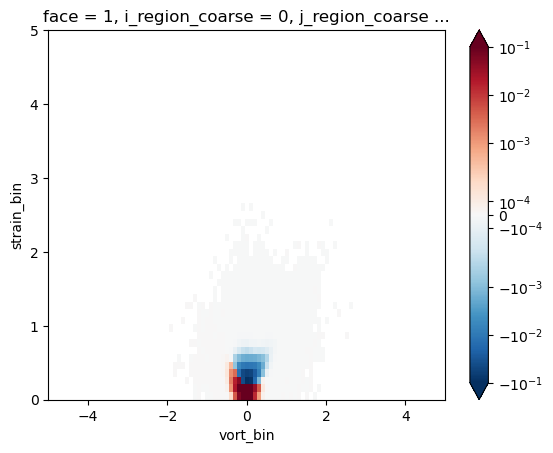

In [9]:
(JPDF_div_JFM*JPDF_JFM).isel(region=24).plot(x='vort_bin', vmax=0.1, norm=mpl.colors.SymLogNorm(4e-4))#

/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3361: UserWarning: Sending large graph of size 16.18 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


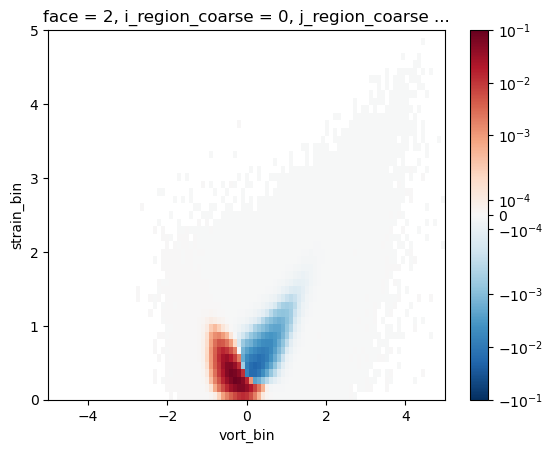

In [10]:
(JPDF_div_JFM*JPDF_JFM).isel(region=76).plot(x='vort_bin', vmax=0.1, norm=mpl.colors.SymLogNorm(4e-4))

In [ ]:
conv_JFM = (JPDF_div_JFM.where((JPDF_div_JFM<0) & (JPDF_div_JFM.vort_bin>0.2))*JPDF_JFM).sum(['vort_bin','strain_bin']).load()

/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3361: UserWarning: Sending large graph of size 17.34 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


<>:24: SyntaxWarning: invalid escape sequence '\z'
<>:24: SyntaxWarning: invalid escape sequence '\z'
/tmp/ipykernel_374/4124746427.py:24: SyntaxWarning: invalid escape sequence '\z'
  plt.title('Jan/Feb/March Total of all convergent JPDF bins with $\zeta>0.2f$')


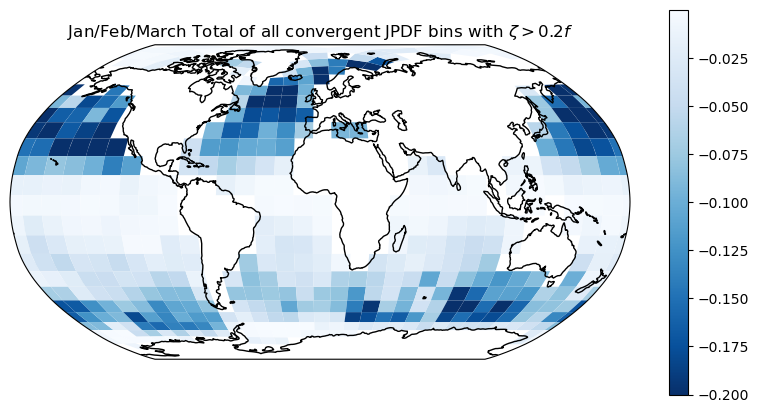

In [14]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.set_global()

ax.coastlines()


from matplotlib.collections import PolyCollection
#fig, ax = plt.subplots()
max_vert = abs(hist_ds.vertices_longitude.diff('vertices')).max('vertices')
hist_ds['lon'] = hist_ds['vertices_longitude'].where((max_vert<100) | (hist_ds.vertices_longitude>-170),hist_ds.vertices_longitude.where((max_vert>100) & (hist_ds.vertices_longitude<-170))+360)
verts = np.stack((hist_ds.lon.values, hist_ds.vertices_latitude.values),2)
verts = np.swapaxes(verts, 0, 1)


# Make the collection and add it to the plot.
coll = PolyCollection(verts, array=conv_JFM, transform=ccrs.PlateCarree(), cmap='Blues_r')
ax.add_collection(coll)
coll.set_clim(vmin=-0.2)
ax.autoscale_view
plt.colorbar(coll)

plt.title('Jan/Feb/March Total of all convergent JPDF bins with $\zeta>0.2f$')
plt.savefig('JFM_conv1.png')

In [15]:
JPDF_div_ASO = (h_ASO.div_bin*h_ASO).mean('div_bin').load()
JPDF_ASO =(h_ASO*h_ASO.div_bin.diff('div_bin')[0]).sum('div_bin')

In [16]:
conv_ASO = (JPDF_div_ASO.where((JPDF_div_ASO<0) & (JPDF_div_ASO.vort_bin>0.2))*JPDF_ASO).sum(['vort_bin','strain_bin']).load()

/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3361: UserWarning: Sending large graph of size 17.47 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


<>:24: SyntaxWarning: invalid escape sequence '\z'
<>:24: SyntaxWarning: invalid escape sequence '\z'
/tmp/ipykernel_374/1776541981.py:24: SyntaxWarning: invalid escape sequence '\z'
  plt.title('Aug/Sept/Oct Total of all convergent JPDF bins with $\zeta>0.2f$')


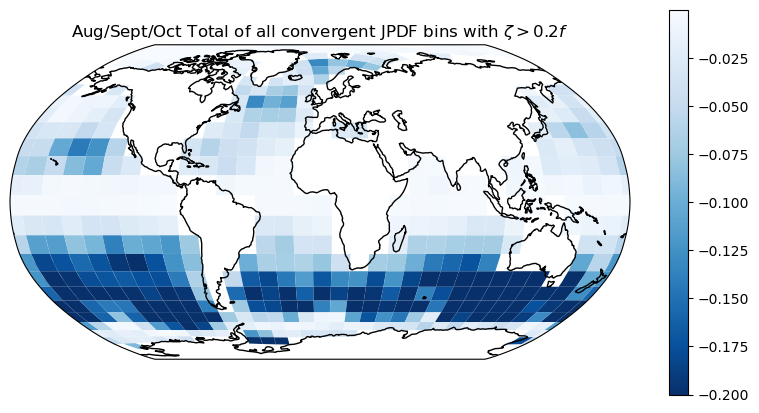

In [17]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

ax.set_global()

ax.coastlines()


from matplotlib.collections import PolyCollection
#fig, ax = plt.subplots()
max_vert = abs(hist_ds.vertices_longitude.diff('vertices')).max('vertices')
hist_ds['lon'] = hist_ds['vertices_longitude'].where((max_vert<100) | (hist_ds.vertices_longitude>-170),hist_ds.vertices_longitude.where((max_vert>100) & (hist_ds.vertices_longitude<-170))+360)
verts = np.stack((hist_ds.lon.values, hist_ds.vertices_latitude.values),2)
verts = np.swapaxes(verts, 0, 1)


# Make the collection and add it to the plot.
coll = PolyCollection(verts, array=conv_ASO, transform=ccrs.PlateCarree(), cmap='Blues_r')
ax.add_collection(coll)
coll.set_clim(vmin=-0.2)
ax.autoscale_view
plt.colorbar(coll)

plt.title('Aug/Sept/Oct Total of all convergent JPDF bins with $\zeta>0.2f$')
plt.savefig('ASO_conv1.png')

In [74]:
conv_ASO

<xarray.DataArray (time: 10, region: 437)> Size: 35kB
array([[-1.31569261e-03, -2.73591285e-06, -1.64597149e-06, ...,
        -5.57507137e-04, -2.98980477e-03, -1.58195014e-03],
       [-2.18425116e-03, -5.09273628e-06, -3.20306672e-06, ...,
        -8.47945407e-04, -5.66295834e-03, -3.26415749e-03],
       [-4.63457652e-04, -7.40804196e-07, -3.29797349e-06, ...,
        -2.48269690e-04, -2.17524443e-03, -1.05349495e-03],
       ...,
       [-1.40664489e-03, -6.75529168e-06, -9.19695347e-07, ...,
        -2.71284572e-05, -6.65291020e-03, -5.24904996e-04],
       [-1.97828099e-03, -1.01382511e-05, -7.78220786e-07, ...,
        -5.56498441e-05, -1.50521960e-02, -2.04282482e-03],
       [-1.05553842e-03, -8.15928885e-06, -6.22133829e-07, ...,
        -8.72231427e-05, -9.91181996e-03, -1.92642947e-03]])
Coordinates:
    face             (region) int64 3kB 0 0 0 0 0 0 0 0 ... 12 12 12 12 12 12 12
    i_region_coarse  (region) int64 3kB 0 0 0 0 1 1 1 2 2 ... 2 2 2 2 2 3 3 3 3
    j_region_coarse  (region) int64 3kB 4 5 6 7 5 6 7 5 6 ... 2 3 4 6 7 0 1 6 7
  * region_num       (region) int64 3kB 4 5 6 7 13 14 ... 791 792 793 798 799
  * time             (time) datetime64[ns] 80B 2012-08-02 ... 2011-10-27
Dimensions without coordinates: region